# 1D Gaussian
In this notebook, I will develop the framework to use a recurrent inference machine to solve a basic 1D deconvolution problem.

The problem: Given a 1D Gaussian profile convolved with Poisson noise, can we use and RIM to recover the original 1D Gaussian profile.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import sys
sys.path.append("/home/carterrhea/Documents/astroRIM/")  # Full path to AstroRIM module 
from RIM_sequence import RIM
from RIM_model import RIM_Model_1D  # Import name  of architecture to use
from RIM_physical import calc_grad_standard  # Import name of gradient log likelihood
plt.style.use('dark.mplstyle')


2023-07-17 21:03:49.976057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 21:03:51.770147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 21:03:51.771018: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
n = 30  # Size of spectrum
N = 1000  # Number of spectra

## Create Convolved Image

In [3]:
def gaussian(x, mu, sig):
    return 1*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def conv_mat(n):
    """
    Create convolution matrix that is an identity matrix with noise
    """
    conv_mat = np.eye(n)+np.random.normal(0, 0.01, (n,n))
    return conv_mat

def create_convolved(N):
    '''
    Create convolved Gaussian that are 28x28
    Args:
     n - number of Gausians
    Return:
     gaussians - List of convolved Gaussians
    '''
    a = 0.01  # Powerlaw slope
    gaussians_initial = []  # List of initial Gaussians
    powerlaw_conv = []  # List of Powerlaws used in convolution
    gaussians_final = []  # List of final Gaussians after convolution
    noise = []  # List of noises added
    for i in range(N):
        # Create original 1D Gaussian 
        x = np.linspace(-1,1,n)
        gaus_orig = gaussian(x, np.random.uniform(0.001,.1), np.random.uniform(0.001,0.1))
        gaussians_initial.append(gaus_orig)
        # Convolve with additional Gaussian
        conv_mat_ = conv_mat(n)
        gaus_conv = conv_mat_@gaus_orig
        # Add noise
        noise_ = np.random.normal(0,0.1, n)
        gaus_noise = gaus_conv + noise_
        gaussians_final.append(gaus_noise)
        powerlaw_conv.append(conv_mat_)
        noise.append(noise_)

    return gaussians_initial,gaussians_final,powerlaw_conv,noise

# Create N instances
gaussians_initial, gaussians_final,powerlaw_conv,noise = create_convolved(N)


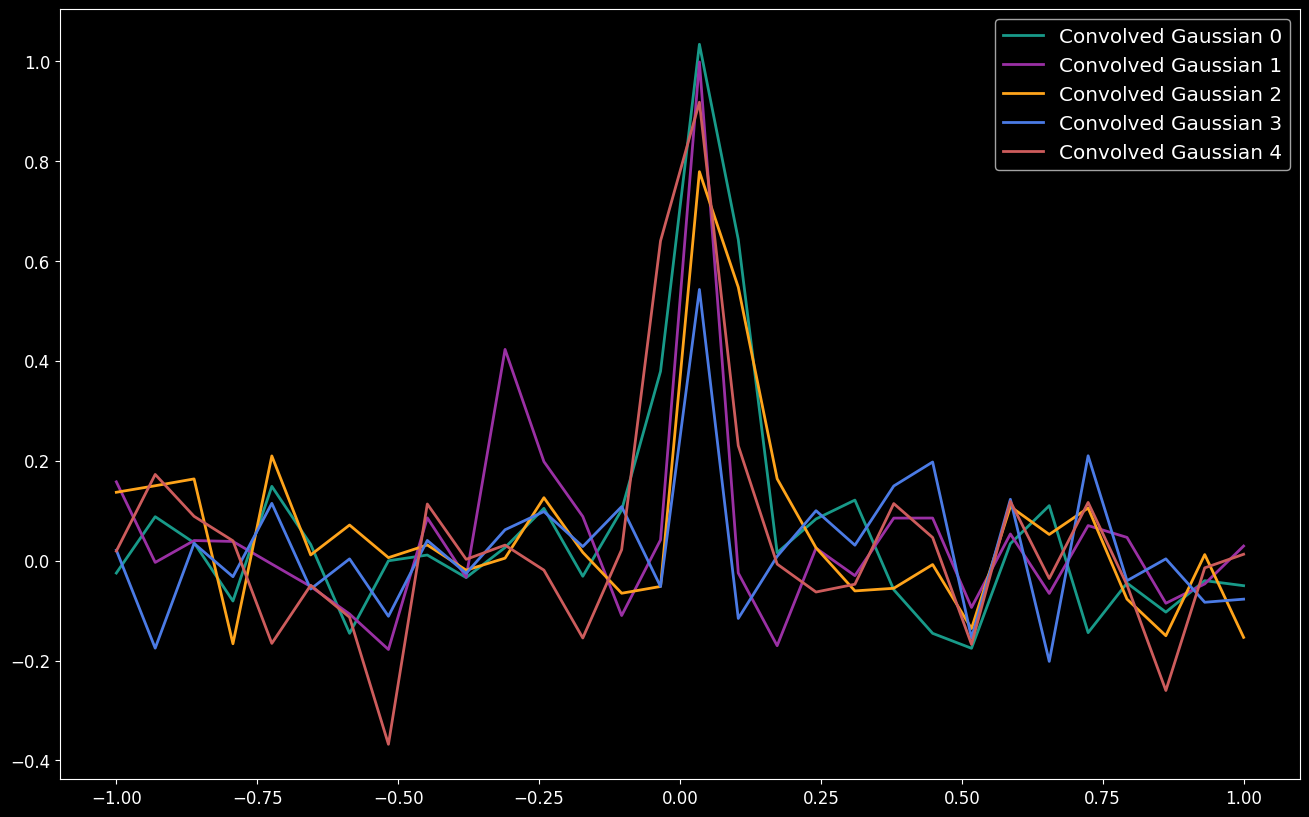

In [4]:
for i in range(5):
    plt.plot(np.linspace(-1,1,n),gaussians_final[i], label='Convolved Gaussian %i'%i)
plt.legend()

## Recurrent Inference Machine

In [5]:
# Create training, validation, and test sets
train_percentage = 0.7
valid_percentage = 0.9
test_percentage = 1.0
len_X = len(gaussians_initial)
# Training
X_train = gaussians_initial[:int(train_percentage*len_X)]
Y_train = gaussians_final[:int(train_percentage*len_X)]
A_train = powerlaw_conv[:int(train_percentage*len_X)]
N_train = noise[:int(train_percentage*len_X)]
#Validation
X_valid = gaussians_initial[int(train_percentage*len_X):int(valid_percentage*len_X)]
Y_valid = gaussians_final[int(train_percentage*len_X):int(valid_percentage*len_X)]
A_valid = powerlaw_conv[int(train_percentage*len_X):int(valid_percentage*len_X)]
N_valid = noise[int(train_percentage*len_X):int(valid_percentage*len_X)]
#Test
X_test = gaussians_initial[int(valid_percentage*len_X):]
Y_test = gaussians_final[int(valid_percentage*len_X):]
A_test = powerlaw_conv[int(valid_percentage*len_X):]
N_test = noise[int(valid_percentage*len_X):]

In [6]:
# Initiate RIM architecture to use. We are using the standard RIM archtecture defined in `rim_model.py` as `RIM_Model_1D`.
rim_architecture = RIM_Model_1D(conv_filters=16, kernel_size=3, rnn_units=[128, 128])
# Load model and define hyper parameters
epochs = 10  # Number of  epochs
batch_size = 16  # Batch size
learning_rate = 1e-2  # Initial learning rate
time_steps = 5  # Time steps
dimensions = 1  # Dimensions of the problem
learning_rate_function  = 'step'  # Type of learning rate function (options are: step, exponential, or linear)
model = RIM(rim_model=rim_architecture, gradient=calc_grad_standard, input_size=n, dimensions=dimensions, t_steps=time_steps, 
            learning_rate=learning_rate, learning_rate_function=learning_rate_function)

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, A_train, N_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(2)
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid, A_valid, N_valid))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.prefetch(2)

In [7]:
# Fit model
ysol_valid, training_loss, valid_loss, learning_rates = model.fit(batch_size, epochs, train_dataset, val_dataset)

Training epoch: 1::  Completion: 0.00%  ETA 00:10:11  loss: 6.558E+00  MSE: 1.198E+01
Training epoch: 1::  Completion: 23.26%  ETA 00:00:25  loss: 9.139E-01  MSE: 2.593E+00
Training epoch: 1::  Completion: 46.51%  ETA 00:00:08  loss: 9.270E-01  MSE: 1.797E+00
Training epoch: 1::  Completion: 69.77%  ETA 00:00:04  loss: 9.323E-01  MSE: 1.514E+00
Training epoch: 1::  Completion: 93.02%  ETA 00:00:01  loss: 9.239E-01  MSE: 1.369E+00
Validation epoch: 1::  Completion: 0.00%  ETA: 00:02:15  train_loss: 9.221E-01  train_MSE: 1.348E+00  val_loss: 9.141E-01 val_MSE: 9.141E-01
Validation epoch: 1::  Completion: 23.26%  ETA: 00:00:02  train_loss: 9.221E-01  train_MSE: 1.348E+00  val_loss: 9.227E-01 val_MSE: 9.186E-01
Validation epoch: 1::  Completion: 100.00%  ETA: 0  train_loss: 9.221E-01  train_MSE: 1.348E+00  val_loss: 9.212E-01 val_MSE: 9.189E-01

Training MSE: 1.3483
Validation MSE: 0.9189
Time taken on epoch: 00:00:44 seconds 


Training epoch: 2::  Completion: 0.00%  ETA 00:00:29  loss: 9

KeyboardInterrupt: 

In [ ]:
plt.plot(np.linspace(-1,1,n), [sol for sol in ysol_valid.numpy()[-1,:]], label='Predicted')
plt.plot(np.linspace(-1,1,n), X_valid[-1], label='True')
plt.legend()

In [ ]:
plt.plot(np.linspace(0, epochs, epochs), training_loss, label='training')
plt.plot(np.linspace(0, epochs, epochs), valid_loss, label='validation')
plt.legend()

In [ ]:
#test_dataset = (Y_test, A_test)#tf.data.Dataset.from_tensor_slices((Y_test, A_test))
test_dataset = tf.data.Dataset.from_tensor_slices((Y_test, A_test, N_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
ysol = model(test_dataset)

In [ ]:
#ysol = [val.numpy() for val in ysol[0]]
ysol_list = []
for val in ysol:
    ysol_ = [val.numpy() for val in val]
    ysol_list.append(ysol_)


In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy', color='C1')
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_noisy.png')

In [ ]:


fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy', color='C1')
plt.plot(np.linspace(-1,1,n), X_test[-1], label='True', color='C8', linewidth=4)
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_noisy_true.png')

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy', color='C1')
plt.plot(np.linspace(-1,1,n), X_test[-1], label='True', color='C8', linewidth=4)
plt.plot(np.linspace(-1,1,n), ysol_list[-1][-1][-1].reshape(n), label='Predicted', linestyle='dashed', color='C6', linewidth=3)
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_complete.png')

### 